# Face Mask Detection using NVIDIA TLT 

The MIT License (MIT)

Copyright (c) 2019-2020, NVIDIA CORPORATION.

Permission is hereby granted, free of charge, to any person obtaining a copy of
this software and associated documentation files (the "Software"), to deal in
the Software without restriction, including without limitation the rights to
use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
the Software, and to permit persons to whom the Software is furnished to do so,
subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

## DetectNet_v2 with ResNet-18 example usecase

The goal of this notebook is to utilize NVIDIA TLT to train and make Face Mask detection model deploy ready.
While working on such application, this notebook will serve as an example usecase of Object Detection using DetectNet_v2 in the Transfer Learning Toolkit.

0. [Set up env variables](#head-0)
1. [Prepare dataset and pre-trained model](#head-1)
    1. [Download dataset and convert in KITTI Format](#head-1-1)
    1. [Prepare tfrecords from kitti format dataset](#head-1-2)
    2. [Download pre-trained model](#head-1-3)
2. [Provide training specification](#head-2)
3. [Run TLT training](#head-3)
4. [Evaluate trained models](#head-4)
5. [Prune trained models](#head-5)
6. [Retrain pruned models](#head-6)
7. [Evaluate retrained model](#head-7)
8. [Visualize inferences](#head-8)
9. [Deploy](#head-9)
    1. [Int8 Optimization](#head-9-1)
    2. [Generate TensorRT engine](#head-9-2)
10. [Verify Deployed Model](#head-10)
    1. [Inference using TensorRT engine](#head-10-1)

![Face Mask Detection Output](https://raw.githubusercontent.com/NVIDIA-AI-IOT/face-mask-detection/master/images/face-mask-detect-output.png)

## 0. Set up env variables <a class="anchor" id="head-0"></a>
When using the purpose-built pretrained models from NGC, please make sure to set the `$KEY` environment variable to the key as mentioned in the model overview. Failing to do so, can lead to errors when trying to load them as pretrained models.

*Note: Please make sure to remove any stray artifacts/files from the `$USER_EXPERIMENT_DIR` or `$DATA_DOWNLOAD_DIR` paths as mentioned below, that may have been generated from previous experiments. Having checkpoint files etc may interfere with creating a training graph for a new experiment.*

In [3]:
# Setting up env variables for cleaner command line commands.
print("Update directory paths if needed")
%env KEY=tlt_encode
# User directory - pre-trained/unpruned/pruned/final models will be saved here
%env USER_EXPERIMENT_DIR=/workspace/detectnet_v2 
# Download directory - tfrecords will be generated here
%env DATA_DOWNLOAD_DIR=/workspace/6000-all-kitti-format           
# Spec Directory
%env SPECS_DIR=/workspace/tlt_specs   
# Number of GPUs used for training
%env NUM_GPUS=1

# !tlt-converter -k $KEY                                    \
#               -d 3,544,960                              \
#               -o output_cov/Sigmoid,output_bbox/BiasAdd \
#               -e resnet18_detector.trt    \
#               -m 16                                     \
#               -t fp32                                   \
#               resnet18_detector.etlt

Update directory paths if needed
env: KEY=tlt_encode
env: USER_EXPERIMENT_DIR=/workspace/detectnet_v2
env: DATA_DOWNLOAD_DIR=/workspace/6000-all-kitti-format
env: SPECS_DIR=/workspace/tlt_specs
env: NUM_GPUS=1


## 1. Prepare dataset and pre-trained model <a class="anchor" id="head-1"></a>

### A. Download dataset and convert in KITTI Format <a class="anchor" id="head-1-1"></a>

In this experiment we will be using 4 different datasets; 

1. Faces with Mask:
    - Kaggle Medical Mask Dataset [Download Link](https://www.kaggle.com/ivandanilovich/medical-masks-dataset-images-tfrecords)
    - MAFA - MAsked FAces [Download Link](https://drive.google.com/drive/folders/1nbtM1n0--iZ3VVbNGhocxbnBGhMau_OG)
2. Faces without Mask:
    - FDDB Dataset [Download Link](http://vis-www.cs.umass.edu/fddb/)
    - WiderFace Dataset [Download Link](http://shuoyang1213.me/WIDERFACE/)

- Download the data using provided links, such that all images and label files are in one folder. We expect in structure noted in GitHub repo.
- Convert dataset to KITTI format 
- Use KITTI format directory as "$DATA_DOWNLOAD_DIR"


Note: We do not use all the images from MAFA and WiderFace. Combining we will use about 6000 faces each with and without mask

### B. Prepare tf records from kitti format dataset <a class="anchor" id="head-1-2"></a>

* Update the tfrecords spec file to take in your kitti format dataset
* Create the tfrecords using the tlt-dataset-convert 

*Note: TfRecords only need to be generated once.*

In [4]:
print("TFrecords conversion spec file for kitti training")
!cat $SPECS_DIR/detectnet_v2_tfrecords_kitti_trainval.txt

TFrecords conversion spec file for kitti training
kitti_config {
  root_directory_path: "/workspace/6000-all-kitti-format/train"
  image_dir_name: "images"
  label_dir_name: "labels"
  image_extension: ".jpg"
  partition_mode: "random"
  num_partitions: 2
  val_split: 20
  num_shards: 10 }


In [5]:
# Creating a new directory for the output tfrecords dump.
print("Converting Tfrecords for kitti trainval dataset")
!tlt-dataset-convert -d $SPECS_DIR/detectnet_v2_tfrecords_kitti_trainval.txt \
                     -o $DATA_DOWNLOAD_DIR/tfrecords/kitti_trainval/kitti_trainval

Converting Tfrecords for kitti trainval dataset
2021-12-15 16:47:12.907702: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
Using TensorFlow backend.
2021-12-15 16:47:16,797 - iva.detectnet_v2.dataio.build_converter - INFO - Instantiating a kitti converter
2021-12-15 16:47:16,797 - iva.detectnet_v2.dataio.dataset_converter_lib - INFO - Creating output directory /workspace/6000-all-kitti-format/tfrecords/kitti_trainval
2021-12-15 16:47:16,816 - iva.detectnet_v2.dataio.kitti_converter_lib - INFO - Num images in
Train: 3899	Val: 974
2021-12-15 16:47:16,816 - iva.detectnet_v2.dataio.kitti_converter_lib - INFO - Validation data in partition 0. Hence, while choosing the validationset during training choose validation_fold 0.
2021-12-15 16:47:16,822 - iva.detectnet_v2.dataio.dataset_converter_lib - INFO - Writing partition 0, shard 0

2021-12-15 16:47:16,822 - tensorflow - WARNING - From /home/vpraveen/.cache/dazel/_dazel_v

Top left coordinate must be less than bottom right.Error in object 0 of label_file /workspace/6000-all-kitti-format/train/labels/56_mask.txt. 
Coordinates: x1 = 357, x2 = 306, y1: 241, y2: 295
Skipping this object
Top left coordinate must be less than bottom right.Error in object 1 of label_file /workspace/6000-all-kitti-format/train/labels/56_mask.txt. 
Coordinates: x1 = 162, x2 = 100, y1: 261, y2: 310
Skipping this object
Top left coordinate must be less than bottom right.Error in object 2 of label_file /workspace/6000-all-kitti-format/train/labels/56_mask.txt. 
Coordinates: x1 = 487, x2 = 412, y1: 178, y2: 259
Skipping this object
Top left coordinate must be less than bottom right.Error in object 3 of label_file /workspace/6000-all-kitti-format/train/labels/56_mask.txt. 
Coordinates: x1 = 97, x2 = 69, y1: 217, y2: 244
Skipping this object
Top left coordinate must be less than bottom right.Error in object 0 of label_file /workspace/6000-all-kitti-format/train/labels/8_mask.txt. 
Coor

Top left coordinate must be less than bottom right.Error in object 0 of label_file /workspace/6000-all-kitti-format/train/labels/train_00000572.txt. 
Coordinates: x1 = 639, x2 = 57, y1: 117, y2: 307
Skipping this object
Top left coordinate must be less than bottom right.Error in object 0 of label_file /workspace/6000-all-kitti-format/train/labels/154_mask.txt. 
Coordinates: x1 = 766, x2 = 573, y1: 84, y2: 323
Skipping this object
Top left coordinate must be less than bottom right.Error in object 0 of label_file /workspace/6000-all-kitti-format/train/labels/403_mask.txt. 
Coordinates: x1 = 667, x2 = 506, y1: 181, y2: 341
Skipping this object
Top left coordinate must be less than bottom right.Error in object 0 of label_file /workspace/6000-all-kitti-format/train/labels/82_mask.txt. 
Coordinates: x1 = 884, x2 = 828, y1: 229, y2: 302
Skipping this object
Top left coordinate must be less than bottom right.Error in object 1 of label_file /workspace/6000-all-kitti-format/train/labels/82_mask.

In [6]:
!ls -rlt $DATA_DOWNLOAD_DIR/tfrecords/kitti_trainval/

total 3324
-rw-r--r-- 1 root root  66708 Dec 15 16:47 kitti_trainval-fold-000-of-002-shard-00000-of-00010
-rw-r--r-- 1 root root  66246 Dec 15 16:47 kitti_trainval-fold-000-of-002-shard-00001-of-00010
-rw-r--r-- 1 root root  67102 Dec 15 16:47 kitti_trainval-fold-000-of-002-shard-00002-of-00010
-rw-r--r-- 1 root root  67295 Dec 15 16:47 kitti_trainval-fold-000-of-002-shard-00003-of-00010
-rw-r--r-- 1 root root  76250 Dec 15 16:47 kitti_trainval-fold-000-of-002-shard-00004-of-00010
-rw-r--r-- 1 root root  63566 Dec 15 16:47 kitti_trainval-fold-000-of-002-shard-00005-of-00010
-rw-r--r-- 1 root root  74756 Dec 15 16:47 kitti_trainval-fold-000-of-002-shard-00006-of-00010
-rw-r--r-- 1 root root  66237 Dec 15 16:47 kitti_trainval-fold-000-of-002-shard-00007-of-00010
-rw-r--r-- 1 root root  66022 Dec 15 16:47 kitti_trainval-fold-000-of-002-shard-00008-of-00010
-rw-r--r-- 1 root root  67875 Dec 15 16:47 kitti_trainval-fold-000-of-002-shard-00009-of-00010
-rw-r--r-- 1 root root 260070 Dec 15 16

### C. Download pre-trained model <a class="anchor" id="head-1-3"></a>
Download the correct pretrained model from the NGC model registry for your experiment. Please note that for DetectNet_v2, the input is expected to be 0-1 normalized with input channels in RGB order. Therefore, for optimum results please download models with `*_detectnet_v2` in their name string. All other models expect input preprocessing with mean subtraction and input channels in BGR order. Thus, using them as pretrained weights may result in suboptimal performance. 

In [7]:
# List models available in the model registry.
!ngc registry model list nvidia/tlt_pretrained_detectnet_v2:*

+-------+-------+-------+-------+-------+-------+-------+-------+-------+
| Versi | Accur | Epoch | Batch | GPU   | Memor | File  | Statu | Creat |
| on    | acy   | s     | Size  | Model | y Foo | Size  | s     | ed    |
|       |       |       |       |       | tprin |       |       | Date  |
|       |       |       |       |       | t     |       |       |       |
+-------+-------+-------+-------+-------+-------+-------+-------+-------+
| vgg19 | 82.6  | 80    | 1     | V100  | 153.8 | 153.7 | UPLOA | Apr   |
|       |       |       |       |       |       | 7 MB  | D_COM | 29,   |
|       |       |       |       |       |       |       | PLETE | 2020  |
| vgg16 | 82.2  | 80    | 1     | V100  | 113.2 | 113.2 | UPLOA | Apr   |
|       |       |       |       |       |       | MB    | D_COM | 29,   |
|       |       |       |       |       |       |       | PLETE | 2020  |
| squee | 65.67 | 80    | 1     | V100  | 6.5   | 6.46  | UPLOA | Apr   |
| zenet |       |       |       |     

In [8]:
# Create the target destination to download the model.
!mkdir -p $USER_EXPERIMENT_DIR/pretrained_resnet18/

In [9]:
# Download the pretrained model from NGC
!ngc registry model download-version nvidia/tlt_pretrained_detectnet_v2:resnet18 \
    --dest $USER_EXPERIMENT_DIR/pretrained_resnet18

Downloaded 82.28 MB in 13s, Download speed: 6.32 MB/s               
----------------------------------------------------
Transfer id: tlt_pretrained_detectnet_v2_vresnet18 Download status: Completed.
Downloaded local path: /workspace/detectnet_v2/pretrained_resnet18/tlt_pretrained_detectnet_v2_vresnet18
Total files downloaded: 1 
Total downloaded size: 82.28 MB
Started at: 2021-12-15 16:51:32.688859
Completed at: 2021-12-15 16:51:45.704870
Duration taken: 13s
----------------------------------------------------


In [10]:
!ls -rlt $USER_EXPERIMENT_DIR/pretrained_resnet18/tlt_pretrained_detectnet_v2_vresnet18

total 91160
-rw------- 1 root root 93345248 Dec 15 16:51 resnet18.hdf5


## 2. Provide training specification <a class="anchor" id="head-2"></a>
* Tfrecords for the train datasets
    * In order to use the newly generated tfrecords, update the dataset_config parameter in the spec file at `$SPECS_DIR/detectnet_v2_train_resnet18_kitti.txt` 
    * Update the fold number to use for evaluation. In case of random data split, please use fold `0` only
    * For sequence-wise split, you may use any fold generated from the dataset convert tool
* Pre-trained models
* Augmentation parameters for on the fly data augmentation
* Other training (hyper-)parameters such as batch size, number of epochs, learning rate etc.

In [11]:
!cat $SPECS_DIR/detectnet_v2_train_resnet18_kitti.txt

random_seed: 42
dataset_config {
  data_sources {
    tfrecords_path: "/workspace/6000-all-kitti-format/tfrecords/kitti_trainval/*"
    image_directory_path: "/workspace/6000-all-kitti-format/train"
  }
  image_extension: "jpg"
  target_class_mapping {
    key: "mask"
    value: "mask"
  }
  target_class_mapping {
    key: "no-mask"
    value: "no-mask"
  }
  validation_fold: 0
  #validation_data_source: {
    #tfrecords_path: "/home/data/tfrecords/kitti_val/*"
    #image_directory_path: "/home/data/test"
  #}
}


augmentation_config {
  preprocessing {
    output_image_width: 960
    output_image_height: 544
    min_bbox_width: 1.0
    min_bbox_height: 1.0
    output_image_channel: 3
  }
  spatial_augmentation {
    hflip_probability: 0.5
    vflip_probability: 0.0
    zoom_min: 1.0
    zoom_max: 1.0
    translate_max_x: 8.0
    translate_max_y: 8.0
  }
  color_augmentation {
    hue_rotation_max: 25.0
    saturation_shift_max: 0.20000000298
    contrast_scale_max: 0.10000000149
    c

## 3. Run TLT training <a class="anchor" id="head-3"></a>
* Provide the sample spec file and the output directory location for models

*Note: The training may take hours to complete. Also, the remaining notebook, assumes that the training was done in single-GPU mode. When run in multi-GPU mode, please expect to update the pruning and inference steps with new pruning thresholds and updated parameters in the clusterfile.json accordingly for optimum performance.*

*Detectnet_v2 now supports restart from checkpoint. Incase, the training job is killed prematurely, you may resume training from the closest checkpoint by simply re-running the same command line. Please do make sure to use the same number of GPUs when restarting the training.*

In [25]:
!tlt-train detectnet_v2 -e $SPECS_DIR/detectnet_v2_train_resnet18_kitti.txt \
                        -r $USER_EXPERIMENT_DIR/experiment_dir_unpruned \
                        -k $KEY \
                        -n resnet18_detector \
                        --gpus $NUM_GPUS

Using TensorFlow backend.
2020-12-11 17:58:10.687554: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-12-11 17:58:12.597452: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-12-11 17:58:12.613491: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-12-11 17:58:12.613957: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce RTX 2070 Super major: 7 minor: 5 memoryClockRate(GHz): 1.38
pciBusID: 0000:01:00.0
2020-12-11 17:58:12.613976: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-12-11 17:58:12.614009: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully o

2020-12-11 17:58:20,408 [INFO] iva.detectnet_v2.dataloader.default_dataloader: Bounding box coordinates were detected in the input specification! Bboxes will be automatically converted to polygon coordinates.
2020-12-11 17:58:20.438064: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-12-11 17:58:20.438454: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce RTX 2070 Super major: 7 minor: 5 memoryClockRate(GHz): 1.38
pciBusID: 0000:01:00.0
2020-12-11 17:58:20.438499: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-12-11 17:58:20.438554: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2020-12-11 17:58:20.438590: I tensorflow/stream_executor/platfor

2020-12-11 17:58:47,315 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 0/120: loss: 0.09403 Time taken: 0:00:00 ETA: 0:00:00
2020-12-11 17:58:47,315 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 1.703
2020-12-11 17:58:55,650 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 15.347
2020-12-11 17:59:03,085 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 26.898
2020-12-11 17:59:09,329 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 32.035
2020-12-11 17:59:15,619 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.798
2020-12-11 17:59:22,039 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.154
2020-12-11 17:59:28,560 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 30.669
2020-12-11 17:59:35,029 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 30.920
2020-12-11 17:59:41,287 [INFO] modulus.hooks.sample_counter_hook: Train S

2020-12-11 18:07:30,122 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 30.454
2020-12-11 18:07:37,394 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 27.503
2020-12-11 18:07:44,412 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 28.499
2020-12-11 18:07:51,072 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 30.030
2020-12-11 18:07:57,933 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 29.154
2020-12-11 18:08:04,931 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 28.577
2020-12-11 18:08:14,117 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 21.775
2020-12-11 18:08:22,719 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 23.250
2020-12-11 18:08:30,114 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 27.046
2020-12-11 18:08:37,723 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 26.284
2020-12-11 18:08:45,331 [INFO] modulus.hooks.sample_counter_

2020-12-11 18:17:03,627 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 30.308
2020-12-11 18:17:10,226 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 30.309
2020-12-11 18:17:16,792 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 30.457
2020-12-11 18:17:23,351 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 30.496
2020-12-11 18:17:29,869 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 30.686
2020-12-11 18:17:36,438 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 30.447
2020-12-11 18:17:45,477 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 22.125
2020-12-11 18:17:54,281 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 22.718
2020-12-11 18:18:00,981 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 29.851
2020-12-11 18:18:07,400 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.160
2020-12-11 18:18:13,863 [INFO] modulus.hooks.sample_counter_

2020-12-11 18:25:24,087 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 28.865
2020-12-11 18:25:30,814 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 29.733
2020-12-11 18:25:37,307 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 30.804
2020-12-11 18:25:43,708 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.247
2020-12-11 18:25:50,131 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.138
2020-12-11 18:25:56,654 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 30.659
2020-12-11 18:26:03,657 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 28.561
2020-12-11 18:26:10,684 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 28.465
2020-12-11 18:26:18,166 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 26.730
2020-12-11 18:26:25,404 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 27.634
2020-12-11 18:26:32,577 [INFO] modulus.hooks.sample_counter_

2020-12-11 18:34:40,321 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 30.518
2020-12-11 18:34:46,653 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.587
2020-12-11 18:34:53,378 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 29.742
2020-12-11 18:34:59,996 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 30.222
2020-12-11 18:35:06,714 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 29.769
2020-12-11 18:35:13,462 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 29.639
2020-12-11 18:35:20,214 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 29.625
2020-12-11 18:35:26,738 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 30.657
2020-12-11 18:35:33,221 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 30.852
2020-12-11 18:35:39,761 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 30.578
2020-12-11 18:35:46,520 [INFO] modulus.hooks.sample_counter_

2020-12-11 18:43:21,366 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.449
2020-12-11 18:43:27,713 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.511
2020-12-11 18:43:34,063 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.497
2020-12-11 18:43:40,422 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.455
2020-12-11 18:43:46,763 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.540
2020-12-11 18:43:53,103 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.546
2020-12-11 18:43:59,444 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.541
2020-12-11 18:44:05,786 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.540
2020-12-11 18:44:12,139 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.481
2020-12-11 18:44:17,162 [INFO] iva.detectnet_v2.evaluation.evaluation: step 0 / 121, 0.00s/step
2020-12-11 18:44:18,635 [INFO] iva.detectnet_v2.evaluation

2020-12-11 18:50:23,097 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.555
2020-12-11 18:50:29,435 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.559
2020-12-11 18:50:35,775 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.548
2020-12-11 18:50:42,129 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.476
2020-12-11 18:50:48,471 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 23/120: loss: 0.00068 Time taken: 0:02:03.751786 ETA: 3:20:03.923265
2020-12-11 18:50:48,471 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.536
2020-12-11 18:50:54,803 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.589
2020-12-11 18:51:01,137 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.576
2020-12-11 18:51:07,471 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.576
2020-12-11 18:51:13,807 [INFO] modulus.hooks.sample_count

2020-12-11 18:58:50,264 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.566
2020-12-11 18:58:56,604 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.544
2020-12-11 18:59:02,945 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.544
2020-12-11 18:59:03,456 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 27/120: loss: 0.00106 Time taken: 0:02:03.750611 ETA: 3:11:48.806807
2020-12-11 18:59:09,404 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 30.965
2020-12-11 18:59:15,990 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 30.368
2020-12-11 18:59:22,357 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.417
2020-12-11 18:59:28,636 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.852
2020-12-11 18:59:34,919 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.832
2020-12-11 18:59:41,202 [INFO] modulus.hooks.sample_count

2020-12-11 19:05:32,519 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 8.070
2020-12-11 19:05:38,779 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.952
2020-12-11 19:05:45,052 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.883
2020-12-11 19:05:51,320 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.910
2020-12-11 19:05:57,593 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.886
2020-12-11 19:06:03,856 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.935
2020-12-11 19:06:10,132 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.865
2020-12-11 19:06:16,400 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.912
2020-12-11 19:06:22,670 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.900
2020-12-11 19:06:28,933 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.930
2020-12-11 19:06:35,198 [INFO] modulus.hooks.sample_counter_h

2020-12-11 19:13:53,868 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.957
2020-12-11 19:14:00,129 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.946
2020-12-11 19:14:06,392 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.935
2020-12-11 19:14:12,664 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.888
2020-12-11 19:14:18,922 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.959
2020-12-11 19:14:25,184 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.941
2020-12-11 19:14:31,456 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.891
2020-12-11 19:14:37,721 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.920
2020-12-11 19:14:43,976 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.976
2020-12-11 19:14:50,242 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.921
2020-12-11 19:14:56,501 [INFO] modulus.hooks.sample_counter_

2020-12-11 19:22:14,641 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.961
2020-12-11 19:22:20,902 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.943
2020-12-11 19:22:27,158 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.971
2020-12-11 19:22:33,414 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.968
2020-12-11 19:22:39,669 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.975
2020-12-11 19:22:45,926 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.967
2020-12-11 19:22:52,177 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.997
2020-12-11 19:22:58,431 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.982
2020-12-11 19:23:04,698 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.913
2020-12-11 19:23:10,942 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 32.031
2020-12-11 19:23:17,189 [INFO] modulus.hooks.sample_counter_

2020-12-11 19:29:23,739 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 29.754
2020-12-11 19:29:30,522 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 29.487
2020-12-11 19:29:37,397 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 29.093
2020-12-11 19:29:44,147 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 29.632
2020-12-11 19:29:50,531 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.327
2020-12-11 19:29:56,961 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.105
2020-12-11 19:30:04,329 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 27.145
2020-12-11 19:30:10,715 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.318
2020-12-11 19:30:17,022 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.714
2020-12-11 19:30:23,813 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 29.450
2020-12-11 19:30:30,747 [INFO] modulus.hooks.sample_counter_

2020-12-11 19:38:50,886 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 20.565
2020-12-11 19:39:00,130 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 21.637
2020-12-11 19:39:06,511 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.341
2020-12-11 19:39:13,198 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 29.909
2020-12-11 19:39:20,052 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 29.184
2020-12-11 19:39:27,083 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 28.446
2020-12-11 19:39:33,610 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 30.643
2020-12-11 19:39:40,566 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 28.752
2020-12-11 19:39:47,795 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 27.667
2020-12-11 19:39:54,707 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 46/120: loss: 0.00028 Time taken

2020-12-11 19:48:16,752 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 30.213
2020-12-11 19:48:23,392 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 30.123
2020-12-11 19:48:30,262 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 29.111
2020-12-11 19:48:37,316 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 28.357
2020-12-11 19:48:43,583 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.913
2020-12-11 19:48:50,258 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 29.960
2020-12-11 19:48:56,775 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 30.692
2020-12-11 19:49:05,484 [INFO] iva.detectnet_v2.evaluation.evaluation: step 0 / 121, 0.00s/step
2020-12-11 19:49:06,822 [INFO] iva.detectnet_v2.evaluation.evaluation: step 10 / 121, 0.13s/step
2020-12-11 19:49:08,165 [INFO] iva.detectnet_v2.evaluation.evaluation: step 20 / 121, 0.13s/step
2020-12-11 19:49:09,724 [INFO] iva.detectnet_v2.eval

2020-12-11 19:55:17,503 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 30.091
2020-12-11 19:55:24,354 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 29.193
2020-12-11 19:55:30,806 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 30.998
2020-12-11 19:55:35,176 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 53/120: loss: 0.00027 Time taken: 0:02:04.582318 ETA: 2:19:07.015311
2020-12-11 19:55:37,763 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 28.750
2020-12-11 19:55:44,135 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.388
2020-12-11 19:55:50,501 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.417
2020-12-11 19:55:57,004 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 30.757
2020-12-11 19:56:03,522 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 30.683
2020-12-11 19:56:09,794 [INFO] modulus.hooks.sample_count

2020-12-11 20:03:47,976 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.889
2020-12-11 20:03:52,307 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 57/120: loss: 0.00042 Time taken: 0:02:03.333767 ETA: 2:09:30.027302
2020-12-11 20:03:54,320 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.529
2020-12-11 20:04:00,580 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.949
2020-12-11 20:04:06,860 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.851
2020-12-11 20:04:13,160 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.745
2020-12-11 20:04:19,403 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 32.037
2020-12-11 20:04:25,643 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 32.052
2020-12-11 20:04:31,878 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 32.078
2020-12-11 20:04:38,175 [INFO] modulus.hooks.sample_count

2020-12-11 20:10:33,564 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 30.995
2020-12-11 20:10:40,423 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 29.159
2020-12-11 20:10:46,707 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.827
2020-12-11 20:10:53,318 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 30.252
2020-12-11 20:10:59,794 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 30.884
2020-12-11 20:11:06,096 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.740
2020-12-11 20:11:12,323 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 32.121
2020-12-11 20:11:18,567 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 32.029
2020-12-11 20:11:24,950 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.333
2020-12-11 20:11:31,304 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.476
2020-12-11 20:11:37,839 [INFO] modulus.hooks.sample_counter_

2020-12-11 20:19:04,147 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 29.888
2020-12-11 20:19:11,033 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 29.045
2020-12-11 20:19:17,413 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.350
2020-12-11 20:19:23,761 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.506
2020-12-11 20:19:30,273 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 30.716
2020-12-11 20:19:36,545 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.891
2020-12-11 20:19:43,102 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 30.503
2020-12-11 20:19:49,418 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.667
2020-12-11 20:19:55,659 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 32.047
2020-12-11 20:20:02,130 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 30.905
2020-12-11 20:20:08,450 [INFO] modulus.hooks.sample_counter_

2020-12-11 20:27:32,538 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 28.371
2020-12-11 20:27:38,772 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 32.079
2020-12-11 20:27:45,015 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 32.041
2020-12-11 20:27:51,255 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 32.049
2020-12-11 20:27:57,648 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.287
2020-12-11 20:28:03,947 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.752
2020-12-11 20:28:10,194 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 32.018
2020-12-11 20:28:16,749 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 30.508
2020-12-11 20:28:22,992 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 32.041
2020-12-11 20:28:29,231 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 32.056
2020-12-11 20:28:35,474 [INFO] modulus.hooks.sample_counter_

2020-12-11 20:34:30,132 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.589
2020-12-11 20:34:36,569 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.076
2020-12-11 20:34:42,903 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.577
2020-12-11 20:34:49,759 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 29.169
2020-12-11 20:34:56,019 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.951
2020-12-11 20:35:02,280 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.947
2020-12-11 20:35:08,547 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.910
2020-12-11 20:35:14,809 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.940
2020-12-11 20:35:21,065 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.972
2020-12-11 20:35:27,328 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.936
2020-12-11 20:35:30,348 [INFO] /usr/local/lib/python3.6/dist

2020-12-11 20:43:12,569 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 28.826
2020-12-11 20:43:19,455 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 29.047
2020-12-11 20:43:25,697 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 32.041
2020-12-11 20:43:32,270 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 30.427
2020-12-11 20:43:39,181 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 28.941
2020-12-11 20:43:46,203 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 28.482
2020-12-11 20:43:52,928 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 29.743
2020-12-11 20:43:59,171 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 32.036
2020-12-11 20:44:02,675 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 76/120: loss: 0.00034 Time taken: 0:02:10.322526 ETA: 1:35:34.191164
2020-12-11 20:44:05,421 [INFO] modulus.hooks.sample_count

2020-12-11 20:51:59,846 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 29.676
2020-12-11 20:52:06,672 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 29.301
2020-12-11 20:52:13,577 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 28.963
2020-12-11 20:52:19,866 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.805
2020-12-11 20:52:26,129 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.932
2020-12-11 20:52:32,653 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 30.659
2020-12-11 20:52:38,800 [INFO] iva.detectnet_v2.evaluation.evaluation: step 0 / 121, 0.00s/step
2020-12-11 20:52:40,255 [INFO] iva.detectnet_v2.evaluation.evaluation: step 10 / 121, 0.15s/step
2020-12-11 20:52:41,592 [INFO] iva.detectnet_v2.evaluation.evaluation: step 20 / 121, 0.13s/step
2020-12-11 20:52:43,118 [INFO] iva.detectnet_v2.evaluation.evaluation: step 30 / 121, 0.15s/step
2020-12-11 20:52:44,506 [INFO] iva.detectnet_v2.e

2020-12-11 20:59:15,431 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 32.070
2020-12-11 20:59:21,801 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.401
2020-12-11 20:59:23,134 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 83/120: loss: 0.00019 Time taken: 0:02:08.674401 ETA: 1:19:20.952821
2020-12-11 20:59:28,691 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 29.030
2020-12-11 20:59:35,738 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 28.379
2020-12-11 20:59:42,612 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 29.098
2020-12-11 20:59:49,582 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 28.694
2020-12-11 20:59:56,096 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 30.704
2020-12-11 21:00:03,324 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 27.672
2020-12-11 21:00:09,633 [INFO] modulus.hooks.sample_count

2020-12-11 21:07:54,143 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 87/120: loss: 0.00022 Time taken: 0:02:06.474038 ETA: 1:09:33.643266
2020-12-11 21:07:58,786 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.253
2020-12-11 21:08:05,075 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.798
2020-12-11 21:08:11,346 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.895
2020-12-11 21:08:17,626 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.852
2020-12-11 21:08:23,918 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.787
2020-12-11 21:08:30,465 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 30.549
2020-12-11 21:08:36,914 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.013
2020-12-11 21:08:43,390 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 30.884
2020-12-11 21:08:49,829 [INFO] modulus.hooks.sample_count

2020-12-11 21:14:57,022 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.349
2020-12-11 21:15:03,381 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.450
2020-12-11 21:15:09,968 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 30.363
2020-12-11 21:15:16,680 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 29.802
2020-12-11 21:15:23,326 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 30.093
2020-12-11 21:15:29,705 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.353
2020-12-11 21:15:36,162 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 30.976
2020-12-11 21:15:42,912 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 29.629
2020-12-11 21:15:49,153 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 32.050
2020-12-11 21:15:55,402 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 32.003
2020-12-11 21:16:02,033 [INFO] modulus.hooks.sample_counter_

2020-12-11 21:23:37,875 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.102
2020-12-11 21:23:44,134 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.953
2020-12-11 21:23:50,883 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 29.638
2020-12-11 21:23:57,670 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 29.467
2020-12-11 21:24:04,465 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 29.434
2020-12-11 21:24:11,102 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 30.134
2020-12-11 21:24:17,914 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 29.361
2020-12-11 21:24:25,110 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 27.794
2020-12-11 21:24:32,100 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 28.614
2020-12-11 21:24:39,098 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 28.582
2020-12-11 21:24:46,510 [INFO] modulus.hooks.sample_counter_

2020-12-11 21:32:24,507 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 32.059
2020-12-11 21:32:30,745 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 32.062
2020-12-11 21:32:37,024 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.851
2020-12-11 21:32:43,281 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.965
2020-12-11 21:32:49,527 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 32.021
2020-12-11 21:32:55,765 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 32.064
2020-12-11 21:33:02,007 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 32.044
2020-12-11 21:33:08,248 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 32.046
2020-12-11 21:33:14,507 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.958
2020-12-11 21:33:20,740 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 32.085
2020-12-11 21:33:26,995 [INFO] modulus.hooks.sample_counter_

2020-12-11 21:39:16,869 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 32.090
2020-12-11 21:39:23,105 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 32.071
2020-12-11 21:39:29,339 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 32.082
2020-12-11 21:39:35,583 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 32.033
2020-12-11 21:39:41,821 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 32.061
2020-12-11 21:39:48,061 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 32.053
2020-12-11 21:39:54,294 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 32.088
2020-12-11 21:40:00,545 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.997
2020-12-11 21:40:06,782 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 32.065
2020-12-11 21:40:07,290 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 102/120: loss: 0.00029 Time take

2020-12-11 21:47:36,757 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.751
2020-12-11 21:47:43,071 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.679
2020-12-11 21:47:49,359 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.809
2020-12-11 21:47:55,830 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 30.906
2020-12-11 21:48:02,386 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 30.506
2020-12-11 21:48:08,772 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.324
2020-12-11 21:48:15,122 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.494
2020-12-11 21:48:21,365 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 32.037
2020-12-11 21:48:22,364 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 106/120: loss: 0.00020 Time taken: 0:02:03.965776 ETA: 0:28:55.520867
2020-12-11 21:48:27,803 [INFO] modulus.hooks.sample_coun

2020-12-11 21:56:05,255 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.894
2020-12-11 21:56:11,532 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.864
2020-12-11 21:56:17,883 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.493
2020-12-11 21:56:24,137 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.979
2020-12-11 21:56:30,395 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.959
2020-12-11 21:56:36,635 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 32.054
2020-12-11 21:56:42,882 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 32.017
2020-12-11 21:56:46,521 [INFO] iva.detectnet_v2.evaluation.evaluation: step 0 / 121, 0.00s/step
2020-12-11 21:56:47,824 [INFO] iva.detectnet_v2.evaluation.evaluation: step 10 / 121, 0.13s/step
2020-12-11 21:56:49,081 [INFO] iva.detectnet_v2.evaluation.evaluation: step 20 / 121, 0.13s/step
2020-12-11 21:56:50,401 [INFO] iva.detectnet_v2.eval

2020-12-11 22:03:07,174 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.482
2020-12-11 22:03:13,420 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 32.023
2020-12-11 22:03:18,553 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 113/120: loss: 0.00026 Time taken: 0:02:05.522961 ETA: 0:14:38.660730
2020-12-11 22:03:19,840 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.152
2020-12-11 22:03:26,577 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 29.692
2020-12-11 22:03:32,900 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.630
2020-12-11 22:03:39,158 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.961
2020-12-11 22:03:45,747 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 30.355
2020-12-11 22:03:52,101 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.474
2020-12-11 22:03:58,360 [INFO] modulus.hooks.sample_coun

2020-12-11 22:11:35,833 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.804
2020-12-11 22:11:41,599 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 117/120: loss: 0.00037 Time taken: 0:02:03.987748 ETA: 0:06:11.963244
2020-12-11 22:11:42,364 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 30.622
2020-12-11 22:11:48,722 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.458
2020-12-11 22:11:55,080 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.459
2020-12-11 22:12:01,630 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 30.535
2020-12-11 22:12:07,930 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.747
2020-12-11 22:12:14,201 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.894
2020-12-11 22:12:20,469 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 31.910
2020-12-11 22:12:26,769 [INFO] modulus.hooks.sample_coun

In [12]:
print('Model for each epoch:')
print('---------------------')
!ls -lh $USER_EXPERIMENT_DIR/experiment_dir_unpruned/weights

Model for each epoch:
---------------------
ls: cannot access '/workspace/detectnet_v2/experiment_dir_unpruned/weights': No such file or directory


## 4. Evaluate the trained model <a class="anchor" id="head-4"></a>

In [27]:
!tlt-evaluate detectnet_v2 -e $SPECS_DIR/detectnet_v2_train_resnet18_kitti.txt\
                           -m $USER_EXPERIMENT_DIR/experiment_dir_unpruned/weights/resnet18_detector.tlt \
                           -k $KEY

Using TensorFlow backend.
2020-12-11 22:22:04.295022: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-12-11 22:22:06,327 [INFO] iva.detectnet_v2.spec_handler.spec_loader: Merging specification from /workspace/tlt_specs/detectnet_v2_train_resnet18_kitti.txt
2020-12-11 22:22:07.431439: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-12-11 22:22:07.475960: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-12-11 22:22:07.476496: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce RTX 2070 Super major: 7 minor: 5 memoryClockRate(GHz): 1.38
pciBusID: 0000:01:00.0
2020-12-11 22:22:07.476535: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] 

2020-12-11 22:22:10.260736: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-12-11 22:22:10.260927: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce RTX 2070 Super major: 7 minor: 5 memoryClockRate(GHz): 1.38
pciBusID: 0000:01:00.0
2020-12-11 22:22:10.260956: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-12-11 22:22:10.260993: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2020-12-11 22:22:10.261009: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2020-12-11 22:22:10.261025: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library 

## 5. Prune the trained model <a class="anchor" id="head-5"></a>
* Specify pre-trained model
* Equalization criterion (`Applicable for resnets and mobilenets`)
* Threshold for pruning.
* A key to save and load the model
* Output directory to store the model

*Usually, you just need to adjust `-pth` (threshold) for accuracy and model size trade off. Higher `pth` gives you smaller model (and thus higher inference speed) but worse accuracy. The threshold to use is depend on the dataset. A pth value `5.2e-6` is just a start point. If the retrain accuracy is good, you can increase this value to get smaller models. Otherwise, lower this value to get better accuracy.*

*For some internal studies, we have noticed that a pth value of 0.01 is a good starting point for detectnet_v2 models.*

In [ ]:
# Create an output directory if it doesn't exist.
!mkdir -p $USER_EXPERIMENT_DIR/experiment_dir_pruned

In [ ]:
print("Change Threshold (-pth) value according to you experiments")

!tlt-prune -m $USER_EXPERIMENT_DIR/experiment_dir_unpruned/weights/resnet18_detector.tlt \
           -o $USER_EXPERIMENT_DIR/experiment_dir_pruned/resnet18_nopool_bn_detectnet_v2_pruned.tlt \
           -eq union \
           -pth 0.8 \
           -k $KEY

In [ ]:
!ls -rlt $USER_EXPERIMENT_DIR/experiment_dir_pruned/

## 6. Retrain the pruned model <a class="anchor" id="head-6"></a>
* Model needs to be re-trained to bring back accuracy after pruning
* Specify re-training specification with pretrained weights as pruned model.

*Note: For retraining, please set the `load_graph` option to `true` in the model_config to load the pruned model graph. Also, if after retraining, the model shows some decrease in mAP, it could be that the originally trained model, was pruned a little too much. Please try reducing the pruning threshold, thereby reducing the pruning ratio, and use the new model to retrain.*

In [ ]:
# Printing the retrain experiment file. 
# Note: We have updated the experiment file to include the 
# newly pruned model as a pretrained weights and, the
# load_graph option is set to true 
!cat $SPECS_DIR/detectnet_v2_retrain_resnet18_kitti.txt

In [ ]:
# Retraining using the pruned model as pretrained weights 
!tlt-train detectnet_v2 -e $SPECS_DIR/detectnet_v2_retrain_resnet18_kitti.txt \
                        -r $USER_EXPERIMENT_DIR/experiment_dir_retrain \
                        -k $KEY \
                        -n resnet18_detector_pruned \
                        --gpus $NUM_GPUS

In [ ]:
# Listing the newly retrained model.
!ls -rlt $USER_EXPERIMENT_DIR/experiment_dir_retrain/weights

## 7. Evaluate the retrained model <a class="anchor" id="head-7"></a>

This section evaluates the pruned and retrained model, using `tlt-evaluate`.

In [ ]:
!tlt-evaluate detectnet_v2 -e $SPECS_DIR/detectnet_v2_retrain_resnet18_kitti.txt \
                           -m $USER_EXPERIMENT_DIR/experiment_dir_retrain/weights/resnet18_detector_pruned.tlt \
                           -k $KEY

## 8. Visualize inferences <a class="anchor" id="head-8"></a>
In this section, we run the `tlt-infer` tool to generate inferences on the trained models. To render bboxes from more classes, please edit the spec file `detectnet_v2_inference_kitti_tlt.txt` to include all the classes you would like to visualize and edit the rest of the file accordingly.

For this you will need to create `test_images` directory containing at least 8 images with masked and no-masked faces, it can be from test data or simply face captures from your own photos. 

In [28]:
!echo $DATA_DOWNLOAD_DIR

/workspace/6000-all-kitti-format


In [29]:
# Running inference for detection on n images
!tlt-infer detectnet_v2 -e $SPECS_DIR/detectnet_v2_inference_kitti_tlt.txt \
                        -o $USER_EXPERIMENT_DIR/tlt_infer_testing \
                        -i $DATA_DOWNLOAD_DIR/test_images \
                        -k $KEY

Using TensorFlow backend.
2020-12-11 22:33:19.378145: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-12-11 22:33:21,484 [INFO] iva.detectnet_v2.scripts.inference: Creating output inference directory
2020-12-11 22:33:21,484 [INFO] iva.detectnet_v2.scripts.inference: Overlain images will be saved in the output path.
2020-12-11 22:33:21,484 [INFO] iva.detectnet_v2.inferencer.build_inferencer: Constructing inferencer
2020-12-11 22:33:21.485117: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-12-11 22:33:21.485225: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-12-11 22:33:21.485520: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce RTX 2070 Super

The `tlt-infer` tool produces two outputs. 
1. Overlain images in `$USER_EXPERIMENT_DIR/tlt_infer_testing/images_annotated`
2. Frame by frame bbox labels in kitti format located in `$USER_EXPERIMENT_DIR/tlt_infer_testing/labels`

*Note: To run inferences for a single image, simply replace the path to the -i flag in `tlt-infer` command with the path to the image.*

In [32]:
# Simple grid visualizer
import matplotlib.pyplot as plt
import os
from math import ceil
valid_image_ext = ['.jpg', '.png', '.jpeg', '.ppm']

def visualize_images(image_dir, num_cols=4, num_images=10):
    output_path = os.path.join(os.environ['USER_EXPERIMENT_DIR'], image_dir)
    num_rows = int(ceil(float(num_images) / float(num_cols)))
    f, axarr = plt.subplots(num_rows, num_cols, figsize=[80,30])
    f.tight_layout()
    a = [os.path.join(output_path, image) for image in os.listdir(output_path) 
         if os.path.splitext(image)[1].lower() in valid_image_ext]
    for idx, img_path in enumerate(a[:num_images]):
        col_id = idx % num_cols
        row_id = idx // num_cols
        img = plt.imread(img_path)
        axarr[row_id, col_id].imshow(img) 

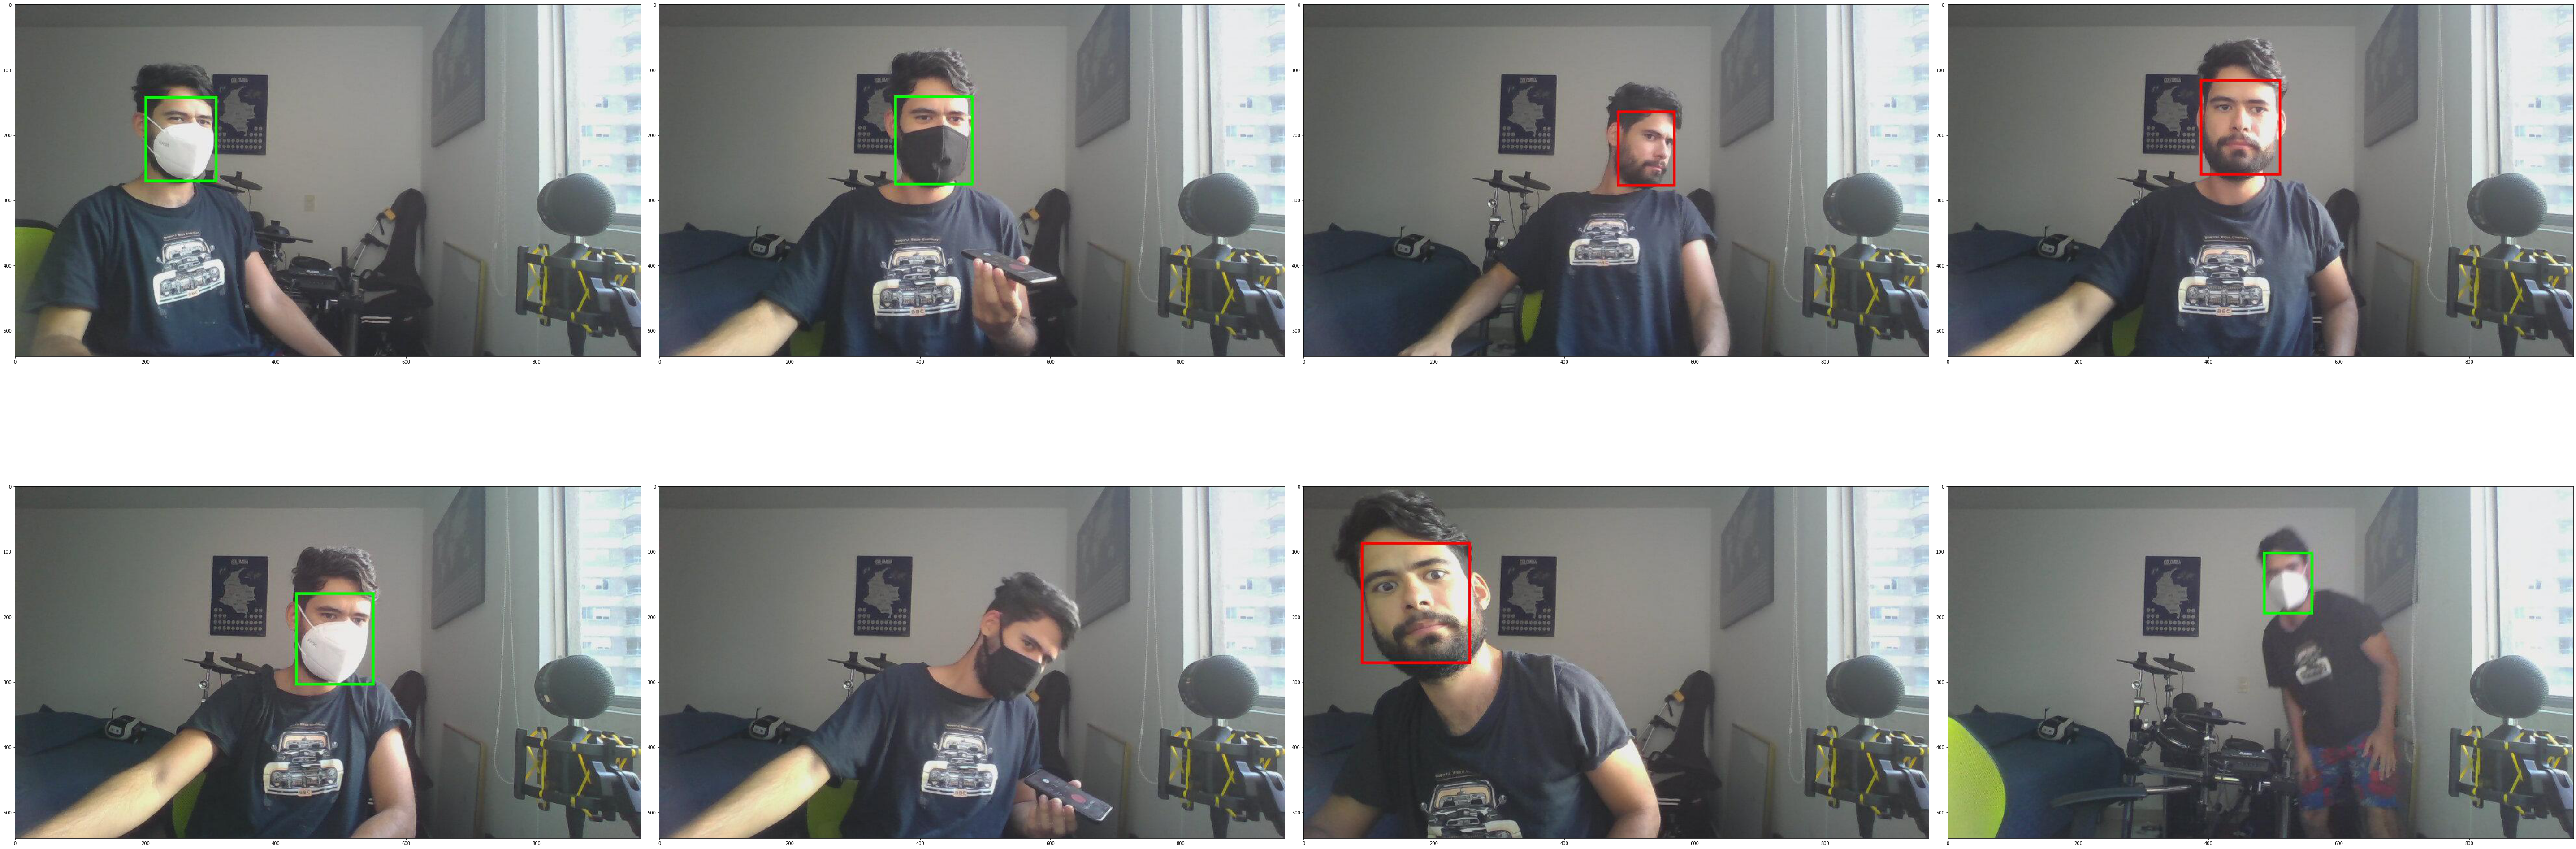

In [33]:
# Visualizing the first 12 images.
OUTPUT_PATH = 'tlt_infer_testing/images_annotated' # relative path from $USER_EXPERIMENT_DIR.
COLS = 4 # number of columns in the visualizer grid.
IMAGES = 8 # number of images to visualize.

visualize_images(OUTPUT_PATH, num_cols=COLS, num_images=IMAGES)

## 9. Deploy! <a class="anchor" id="head-9"></a>

In [4]:
!mkdir -p $USER_EXPERIMENT_DIR/experiment_dir_final
# Removing a pre-existing copy of the etlt if there has been any.
import os
output_file=os.path.join(os.environ['USER_EXPERIMENT_DIR'],
                         "experiment_dir_final/resnet18_detector.etlt")
if os.path.exists(output_file):
    os.system("rm {}".format(output_file))
#             -m $USER_EXPERIMENT_DIR/experiment_dir_retrain/weights/resnet18_detector_pruned.tlt \
!tlt-export detectnet_v2 \
            -m $USER_EXPERIMENT_DIR/experiment_dir_unpruned/weights/resnet18_detector.tlt \
            -o $USER_EXPERIMENT_DIR/experiment_dir_final/resnet18_detector.etlt \
            -k $KEY

Using TensorFlow backend.
2020-12-14 16:45:39.803050: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-12-14 16:45:42.249048: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-12-14 16:45:42.249367: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-12-14 16:45:42.249674: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce RTX 2070 Super major: 7 minor: 5 memoryClockRate(GHz): 1.38
pciBusID: 0000:01:00.0
2020-12-14 16:45:42.249691: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-12-14 16:45:42.249722: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully o

2020-12-14 16:45:49.173813: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-12-14 16:45:49.174177: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce RTX 2070 Super major: 7 minor: 5 memoryClockRate(GHz): 1.38
pciBusID: 0000:01:00.0
2020-12-14 16:45:49.174205: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-12-14 16:45:49.174254: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2020-12-14 16:45:49.174307: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2020-12-14 16:45:49.174321: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library 

## FP16 TRT

In [2]:
!mkdir -p $USER_EXPERIMENT_DIR/experiment_dir_final_rt
# Removing a pre-existing copy of the etlt if there has been any.
import os
output_file=os.path.join(os.environ['USER_EXPERIMENT_DIR'],
                         "experiment_dir_final_rt/resnet18_detector.trt")
if os.path.exists(output_file):
    os.system("rm {}".format(output_file))
    
!tlt-export detectnet_v2 \
            -o resnet18_detector.etl \
            -m $USER_EXPERIMENT_DIR/experiment_dir_unpruned/weights/resnet18_detector.tlt \
            -k $KEY \
            --data_type fp16 \
            --engine_file $USER_EXPERIMENT_DIR/experiment_dir_final_rt/resnet18_detector.trt

Using TensorFlow backend.
2020-12-16 01:12:56.909569: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-12-16 01:12:59.708494: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-12-16 01:12:59.708813: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-12-16 01:12:59.709104: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce RTX 2070 Super major: 7 minor: 5 memoryClockRate(GHz): 1.38
pciBusID: 0000:01:00.0
2020-12-16 01:12:59.709122: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-12-16 01:12:59.709154: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully o

2020-12-16 01:13:06.905177: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-12-16 01:13:06.905471: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce RTX 2070 Super major: 7 minor: 5 memoryClockRate(GHz): 1.38
pciBusID: 0000:01:00.0
2020-12-16 01:13:06.905504: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-12-16 01:13:06.905534: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2020-12-16 01:13:06.905556: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2020-12-16 01:13:06.905569: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library 

In [7]:
print('Exported model:')
print('------------')
!ls -lh $USER_EXPERIMENT_DIR/experiment_dir_final_rt

Exported model:
------------
total 23M
-rw-r--r-- 1 root root 23M Dec 14 16:54 resnet18_detector.trt


In [2]:
import tensorrt as trt
import pycuda.driver as cuda
import pycuda.autoinit
import os
import numpy as np

class HostDeviceMem(object):
    def __init__(self, host_mem, device_mem):
        self.host = host_mem
        self.device = device_mem

    def __str__(self):
        return "Host:\n" + str(self.host) + "\nDevice:\n" + str(self.device)

    def __repr__(self):
        return self.__str__()
    

def load_engine(trt_runtime, engine_path):
    with open(engine_path, 'rb') as f:
        engine_data = f.read()
    engine = trt_runtime.deserialize_cuda_engine(engine_data)
    return engine

def allocate_buffers(engine):
    """Allocates host and device buffer for TRT engine inference.
    This function is similair to the one in common.py, but
    converts network outputs (which are np.float32) appropriately
    before writing them to Python buffer. This is needed, since
    TensorRT plugins doesn't support output type description, and
    in our particular case, we use NMS plugin as network output.
    Args:
        engine (trt.ICudaEngine): TensorRT engine
    Returns:
        inputs [HostDeviceMem]: engine input memory
        outputs [HostDeviceMem]: engine output memory
        bindings [int]: buffer to device bindings
        stream (cuda.Stream): cuda stream for engine inference synchronization
    """
    inputs = []
    outputs = []
    bindings = []
    stream = cuda.Stream()

    # Current NMS implementation in TRT only supports DataType.FLOAT but
    # it may change in the future, which could brake this sample here
    # when using lower precision [e.g. NMS output would not be np.float32
    # anymore, even though this is assumed in binding_to_type]
    binding_to_type = {"input_1": np.float32, "output_bbox/BiasAdd": np.float32, "output_cov/Sigmoid": np.float32}

    for binding in engine:
#         size = trt.volume(engine.get_binding_shape(binding)) * engine.max_batch_size
        size = trt.volume(engine.get_binding_shape(binding)) * 1
        dtype = binding_to_type[str(binding)]
        # Allocate host and device buffers
        host_mem = cuda.pagelocked_empty(size, dtype)
        device_mem = cuda.mem_alloc(host_mem.nbytes)
        # Append the device buffer to device bindings.
        bindings.append(int(device_mem))
        # Append to the appropriate list.
        if engine.binding_is_input(binding):
            inputs.append(HostDeviceMem(host_mem, device_mem))
        else:
            outputs.append(HostDeviceMem(host_mem, device_mem))
    return inputs, outputs, bindings, stream

In [3]:
# TensorRT logger singleton
TRT_LOGGER = trt.Logger(trt.Logger.WARNING)
trt_engine_path = os.path.join(os.environ['USER_EXPERIMENT_DIR'],
                         "experiment_dir_final_rt/resnet18_detector.trt")

trt_runtime = trt.Runtime(TRT_LOGGER)
trt_engine = load_engine(
                trt_runtime, trt_engine_path)


# This allocates memory for network inputs/outputs on both CPU and GPU
inputs, outputs, bindings, stream = allocate_buffers(trt_engine)

# Execution context is needed for inference
context = trt_engine.create_execution_context()

In [4]:
for binding in trt_engine:
    print(binding)
trt_engine.max_batch_size

input_1
output_bbox/BiasAdd
output_cov/Sigmoid


16

In [5]:
import cv2
import time
output_image_width =  960
output_image_height = 544
from PIL import Image

# This function is generalized for multiple inputs/outputs.
# inputs and outputs are expected to be lists of HostDeviceMem objects.
def do_inference(context, bindings, inputs, outputs, stream, batch_size=1):
    # Transfer input data to the GPU.
    [cuda.memcpy_htod_async(inp.device, inp.host, stream) for inp in inputs]
    # Run inference.
    context.execute_async(batch_size=batch_size, bindings=bindings, stream_handle=stream.handle)
    # Transfer predictions back from the GPU.
    [cuda.memcpy_dtoh_async(out.host, out.device, stream) for out in outputs]
    # Synchronize the stream
    stream.synchronize()
    # Return only the host outputs.
    return [out.host for out in outputs]

def process_image(arr, w, h):
    image = Image.fromarray(np.uint8(arr))

    image_resized = image.resize(
        size=(w, h),
        resample=Image.BILINEAR
    )
    img_np = np.array(image_resized)
    # HWC -> CHW
    img_np = img_np.transpose((2, 0, 1))
    # Normalize to [0.0, 1.0] interval (expected by model)
    img_np = (1.0 / 255.0) * img_np 
    print(img_np.shape)
    img_np = img_np.ravel()
    return img_np

def predict(image):
    """Infers model on batch of same sized images resized to fit the model.
    Args:
        image_paths (str): paths to images, that will be packed into batch
            and fed into model
    """
    img = process_image(image,output_image_width,output_image_height )
    print(img.shape)
    # Copy it into appropriate place into memory
    # (self.inputs was returned earlier by allocate_buffers())
    np.copyto(inputs[0].host, img.ravel())

    # When infering on single image, we measure inference
    # time to output it to the user
    inference_start_time = time.time()

    # Fetch output from the model
    [detection_out, keepCount_out] = do_inference(
        context, bindings=bindings, inputs=inputs,
        outputs=outputs, stream=stream)

    # Output inference time
    print("TensorRT inference time: {} ms".format(
        int(round((time.time() - inference_start_time) * 1000))))

    # And return results
    return detection_out, keepCount_out

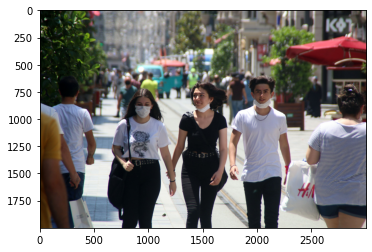

In [6]:
import matplotlib.pyplot as plt
image = cv2.imread("6000-all-kitti-format/test_images/2020-12-11-172854.jpg")[...,::-1]
image = cv2.imread("6000-all-kitti-format/test_images/test.jpg")[...,::-1]

plt.imshow(image)
plt.show()

In [7]:
detection_out, keepCount_out = predict(image)
print(detection_out, keepCount_out)

(3, 544, 960)
(1566720,)
TensorRT inference time: 4 ms
[1.3457031  0.25927734 0.36523438 ... 0.3852539  0.40576172 1.9863281 ] [7.3112547e-05 3.3015272e-04 2.4729347e-04 ... 1.5326108e-05 1.7917988e-05
 6.4895394e-06]


In [8]:
detection_out.shape

(16320,)

In [9]:
keepCount_out.shape

(4080,)

In [19]:
model_h = 544
model_w = 960
stride = 16
box_norm = 35.0

grid_h = int(model_h / stride)
grid_w = int(model_w / stride)
grid_size = grid_h * grid_w

grid_centers_w = []
grid_centers_h = []

for i in range(grid_h):
    value = (i * stride + 0.5) / box_norm
    grid_centers_h.append(value)

for i in range(grid_w):
    value = (i * stride + 0.5) / box_norm
    grid_centers_w.append(value)


def applyBoxNorm(o1, o2, o3, o4, x, y):
    """
    Applies the GridNet box normalization
    Args:
        o1 (float): first argument of the result
        o2 (float): second argument of the result
        o3 (float): third argument of the result
        o4 (float): fourth argument of the result
        x: row index on the grid
        y: column index on the grid

    Returns:
        float: rescaled first argument
        float: rescaled second argument
        float: rescaled third argument
        float: rescaled fourth argument
    """
    o1 = (o1 - grid_centers_w[x]) * -box_norm
    o2 = (o2 - grid_centers_h[y]) * -box_norm
    o3 = (o3 + grid_centers_w[x]) * box_norm
    o4 = (o4 + grid_centers_h[y]) * box_norm
    return o1, o2, o3, o4

classes = ["no", "si"]
def postprocess(outputs, min_confidence, analysis_classes, wh_format=True):
    """
    Postprocesses the inference output
    Args:
        outputs (list of float): inference output
        min_confidence (float): min confidence to accept detection
        analysis_classes (list of int): indices of the classes to consider

    Returns: list of list tuple: each element is a two list tuple (x, y) representing the corners of a bb
        """
            
    bbs = []
    class_ids = []
    scores = []
    for c in range(len(classes)):
        if c not in analysis_classes:
            continue

        x1_idx = (c * 4 * grid_size)
        y1_idx = x1_idx + grid_size
        x2_idx = y1_idx + grid_size
        y2_idx = x2_idx + grid_size

        boxes = outputs[0]
        for h in range(grid_h):
            for w in range(grid_w):
                i = w + h * grid_w
                score = outputs[1][c * grid_size + i]
                if score >= min_confidence:
                    o1 = boxes[x1_idx + w + h * grid_w]
                    o2 = boxes[y1_idx + w + h * grid_w]
                    o3 = boxes[x2_idx + w + h * grid_w]
                    o4 = boxes[y2_idx + w + h * grid_w]

                    o1, o2, o3, o4 = applyBoxNorm(
                        o1, o2, o3, o4, w, h)

                    xmin = int(o1)
                    ymin = int(o2)
                    xmax = int(o3)
                    ymax = int(o4)
                    if wh_format:
                        bbs.append([xmin, ymin, xmax-xmin, ymax-ymin])
                    else:
                        bbs.append([xmin, ymin, xmax, ymax])
                    class_ids.append(c)
                    scores.append(float(score))
                    
    return bbs, class_ids, scores

In [20]:
len(detection_out)

16320

In [21]:
len(keepCount_out)

4080

In [22]:
len(detection_out)/len(keepCount_out)

4.0

In [23]:
detection_out[:4]

array([1.3457031 , 0.25927734, 0.36523438, 0.6855469 ], dtype=float32)

In [27]:
bboxes, class_ids, scores = postprocess([detection_out,keepCount_out], 0.1, list(range(2)))
bboxes

[[276, 223, 52, 47],
 [277, 222, 51, 48],
 [276, 226, 50, 44],
 [275, 223, 51, 47],
 [276, 224, 52, 47],
 [277, 225, 49, 46],
 [277, 225, 51, 47],
 [626, 184, 48, 51],
 [624, 188, 52, 47],
 [625, 187, 49, 48],
 [625, 187, 50, 47],
 [624, 187, 52, 48],
 [625, 187, 50, 49],
 [625, 188, 50, 47],
 [449, 201, 47, 44],
 [624, 190, 50, 47],
 [624, 186, 52, 50],
 [624, 186, 52, 51]]

(2000, 3000, 3)


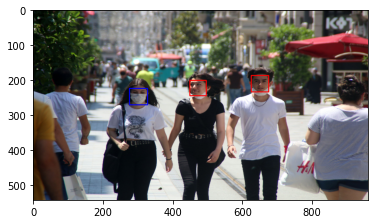

In [29]:
indexes = cv2.dnn.NMSBoxes(bboxes, scores, 0.1, 0.5)

image_cpy = image.copy()
image_cpy = cv2.resize(image_cpy, (model_w, model_h))
print(image.shape)
for idx in indexes:
    idx = int(idx)
    xmin, ymin,w, h = bboxes[idx]
    class_id = class_ids[idx]
    color = [255,0,0] if class_id else [0,0,255]
    cv2.rectangle(image_cpy, (xmin, ymin), (xmin+w, ymin+h), color,2)
plt.imshow(image_cpy)
plt.show()

### A. Int8 Optimization <a class="anchor" id="head-9-1"></a>
DetectNet_v2 model supports int8 inference mode in TRT. In order to use int8 mode, we must calibrate the model to run 8-bit inferences. This involves 2 steps

* Generate calibration tensorfile from the training data using tlt-int8-tensorfile
* Use tlt-export to generate int8 calibration table.

*Note: For this example, we generate a calibration tensorfile containing 10 batches of training data.
Ideally, it is best to use atleast 10-20% of the training data to calibrate the model. The more data provided during calibration, the closer int8 inferences are to fp32 inferences.*

In [ ]:
!tlt-int8-tensorfile detectnet_v2 -e $SPECS_DIR/detectnet_v2_retrain_resnet18_kitti.txt \
                                  -m 40 \
                                  -o $USER_EXPERIMENT_DIR/experiment_dir_final/calibration.tensor

In [ ]:
!rm -rf $USER_EXPERIMENT_DIR/experiment_dir_final/resnet18_detector.etlt
!rm -rf $USER_EXPERIMENT_DIR/experiment_dir_final/calibration.bin
!tlt-export detectnet_v2 \
            -m $USER_EXPERIMENT_DIR/experiment_dir_retrain/weights/resnet18_detector_pruned.tlt \
            -o $USER_EXPERIMENT_DIR/experiment_dir_final/resnet18_detector.etlt \
            -k $KEY  \
            --cal_data_file $USER_EXPERIMENT_DIR/experiment_dir_final/calibration.tensor \
            --data_type int8 \
            --batches 20 \
            --batch_size 4 \
            --max_batch_size 4\
            --engine_file $USER_EXPERIMENT_DIR/experiment_dir_final/resnet18_detector.trt.int8 \
            --cal_cache_file $USER_EXPERIMENT_DIR/experiment_dir_final/calibration.bin \
            --verbose

### B. Generate TensorRT engine <a class="anchor" id="head-9-2"></a>
Verify engine generation using the `tlt-converter` utility included with the docker.

The `tlt-converter` produces optimized tensorrt engines for the platform that it resides on. Therefore, to get maximum performance, please instantiate this docker and execute the `tlt-converter` command, with the exported `.etlt` file and calibration cache (for int8 mode) on your target device. The converter utility included in this docker only works for x86 devices, with discrete NVIDIA GPU's. 

For the jetson devices, please download the converter for jetson from the dev zone link [here](https://developer.nvidia.com/tlt-converter). 

If you choose to integrate your model into deepstream directly, you may do so by simply copying the exported `.etlt` file along with the calibration cache to the target device and updating the spec file that configures the `gst-nvinfer` element to point to this newly exported model. Usually this file is called `config_infer_primary.txt` for detection models and `config_infer_secondary_*.txt` for classification models.

In [ ]:
!tlt-converter $USER_EXPERIMENT_DIR/experiment_dir_final/resnet18_detector.etlt \
               -k $KEY \
               -c $USER_EXPERIMENT_DIR/experiment_dir_final/calibration.bin \
               -o output_cov/Sigmoid,output_bbox/BiasAdd \
               -d 3,544,960 \
               -i nchw \
               -m 64 \
               -t int8 \
               -e $USER_EXPERIMENT_DIR/experiment_dir_final/resnet18_detector.trt \
               -b 4

## 10. Verify Deployed Model <a class="anchor" id="head-10"></a>
Verify the exported model by visualizing inferences on TensorRT.
In addition to running inference on a `.tlt` model in [step 8](#head-8), the `tlt-infer` tool is also capable of consuming the converted `TensorRT engine` from [step 9.B](#head-9-2).

*If after int-8 calibration the accuracy of the int-8 inferences seem to degrade, it could be because the there wasn't enough data in the calibration tensorfile used to calibrate thee model or, the training data is not entirely representative of your test images, and the calibration maybe incorrect. Therefore, you may either regenerate the calibration tensorfile with more batches of the training data, and recalibrate the model, or calibrate the model on a few images from the test set. This may be done using `--cal_image_dir` flag in the `tlt-export` tool. For more information, please follow the instructions in the USER GUIDE.

### A. Inference using TensorRT engine <a class="anchor" id="head-10-1"></a>

In [ ]:
!tlt-infer detectnet_v2 -e $SPECS_DIR/detectnet_v2_inference_kitti_etlt.txt \
                        -o $USER_EXPERIMENT_DIR/etlt_infer_testing \
                        -i $DATA_DOWNLOAD_DIR/test_images \
                        -k $KEY

In [ ]:
# visualize the first 12 inferenced images.
OUTPUT_PATH = 'etlt_infer_testing/images_annotated' # relative path from $USER_EXPERIMENT_DIR.
COLS = 4 # number of columns in the visualizer grid.
IMAGES = 8 # number of images to visualize.

visualize_images(OUTPUT_PATH, num_cols=COLS, num_images=IMAGES)